<a href="https://colab.research.google.com/github/A01793509/Equipo_44/blob/main/Avance2_44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---


🚀 **Avance 2. Ingeniería de características**:

- Crear nuevas características para mejorar el rendimiento de los modelos.
- Mitigar el riesgo de características sesgadas y acelerar la convergencia de algunos algoritmos.

📑 **Asignatura:** Proyecto Integrador

📘 **Proyecto:** LunchForecast AI: Optimizador de reservas de almuerzos empresariales basado en inteligencia artificial.

📚 **Equipo:** 44

🧑 **Alumnos:**
> Alberto José García Porras (Matrícula No. **A01793509**)

>  Erick Johan Najera Olivero (Matrícula No. **A01793506**)

>  Carlos Julio León Caicedo (Matrícula No. **A01793947**)

👩 **Profesores**:
> Dra. Grettel Barceló Alonso

> Dr. Luis Eduardo Falcón Morales

> Dr. Guillermo Mota

📅 Mayo 12 del 2024

---

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

---
##👣**Obtener Datos**: Cargamos el archivo CSV con la información del consumo del casino desde enero del 2021 hasta marzo del 2024.
---

In [32]:
dfCasinoConsumo = pd.read_csv("DatosConsumoCasino.csv",sep=";")
dfCasinoConsumo.head().T

,0,1,2,3,4
Consecutivo,825979,825980,825981,825982,825983
IdProducto,2.0,2.0,2.0,2.0,2.0
cod lector,0,0,0,1,0
Cod comedor,1001,1001,1001,1001,1001
Identificacion persona,100001,100002,100003,100004,100005
Fecha Consumo,3/01/2021,3/01/2021,3/01/2021,3/01/2021,3/01/2021
Detalle,ALMUERZO,ALMUERZO,ALMUERZO,ALMUERZO,ALMUERZO
Nro empleados,3486,3486,3486,3486,3486
Tipo Empleado,Operativo,Administrativo,Operativo,Operativo,Administrativo
Nivel,OPER,ANAL,OPER,OPER,OPER


---
<center> 🤔 Matriz de Correlación entre las variables dependientes e independientes
</center>
---

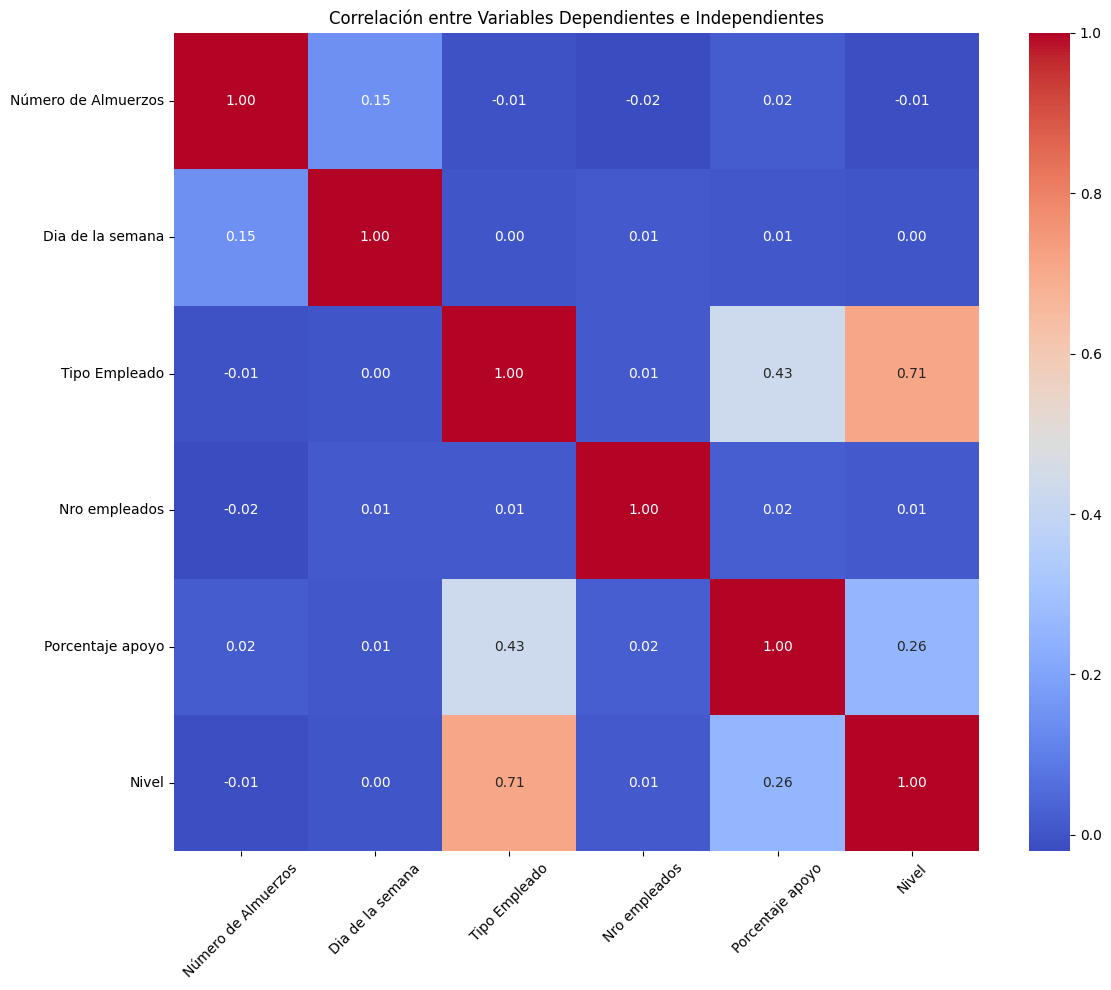

In [86]:
# Preparación de los datos
# Copia del consumo original de comidas relacionadas en el conjunto de datos
dfCasinoConsumoOriginal = dfCasinoConsumo.copy()

# Si la columna necesita ser convertida a datetime (solo si se detectan problemas en la carga directa)
dfCasinoConsumo['Fecha Consumo'] = pd.to_datetime(dfCasinoConsumo['Fecha Consumo'], errors='coerce')
dfCasinoConsumo['Dia de la semana'] = dfCasinoConsumo['Fecha Consumo'].dt.dayofweek # lunes=0, domingo=6

# Se convierte la variable 'Tipo Empleado' de variable categórica a variable numérica
dfCasinoConsumo['Tipo Empleado'] = pd.Categorical(dfCasinoConsumo['Tipo Empleado']).codes

# Nos aseguramos que 'Nro empleados' y 'Porcentaje apoyo' sean variables numéricas
dfCasinoConsumo['Nro empleados'] = pd.to_numeric(dfCasinoConsumo['Nro empleados'], errors='coerce')
dfCasinoConsumo['Porcentaje apoyo'] = pd.to_numeric(dfCasinoConsumo['Porcentaje apoyo'], errors='coerce')

# Se pasa a mayuscula todos los datos de la variable
dfCasinoConsumo['Detalle'] = dfCasinoConsumo['Detalle'].str.upper()

# Filtrar el DataFrame para conservar solo las filas donde 'Detalle' es 'ALMUERZO' y crear una copia para evitar SettingWithCopyWarning
dfCasinoConsumo = dfCasinoConsumo[dfCasinoConsumo['Detalle'] == 'ALMUERZO'].copy()

# Creamos una columna auxiliar 'Conteo Almuerzos' con todos los valores iguales a 1 para facilitar la suma
dfCasinoConsumo.loc[:, 'Conteo Almuerzos'] = 1

# Luego, agrupamos los datos por 'Día de la semana' y sumamos el 'Conteo Almuerzos' para obtener el 'Número de Almuerzos' total por cada día de la semana
dfCasinoConsumo['Número de Almuerzos'] = dfCasinoConsumo.groupby('Dia de la semana')['Conteo Almuerzos'].transform('sum')

# Continuando con la preparación de los datos:
dfCasinoConsumo['Tipo Empleado'] = pd.Categorical(dfCasinoConsumo['Tipo Empleado']).codes # Convertir 'Tipo Empleado' en variable numérica
dfCasinoConsumo['Detalle'] = pd.Categorical(dfCasinoConsumo['Detalle']).codes  # Convertir 'Detalle' en variable numérica, se dejo solo ALMUERZO
dfCasinoConsumo['Nivel'] = pd.Categorical(dfCasinoConsumo['Nivel']).codes      # Convertir 'Nivel' en variable numérica
dfCasinoConsumo['Nro empleados'] = pd.to_numeric(dfCasinoConsumo['Nro empleados'], errors='coerce')
dfCasinoConsumo['Porcentaje apoyo'] = pd.to_numeric(dfCasinoConsumo['Porcentaje apoyo'], errors='coerce')

# Cada registro en el dataframe representa un ALMUERZO, CENA, O COMIDA consumida
dfCasinoConsumo['Número de Almuerzos'] = dfCasinoConsumo.groupby('Dia de la semana')['Dia de la semana'].transform('count')

# Eliminamos las filas con valores NaN en las columnas relevantes para asegurarnos de que la correlación no se vea afectada por los datos faltantes.
dfCasinoConsumo.dropna(subset=['Número de Almuerzos', 'Dia de la semana', 'Tipo Empleado', 'Nro empleados', 'Porcentaje apoyo', 'Nivel'], inplace=True)

# Finalmente se crea la Matriz de Correlación entre las variables seleccionadas, se quita la variable Detalle
correlation_matrix = dfCasinoConsumo[['Número de Almuerzos', 'Dia de la semana', 'Tipo Empleado', 'Nro empleados', 'Porcentaje apoyo', 'Nivel']].corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre Variables Dependientes e Independientes')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
#####🔎 Algunas de las conclusiones obtenidas para calcular la corrrelación entre las variables dependientes e independientes:
*   Las variables **"Invitado"** y **"Ing x planta"** no presentaban variación, dado que todos sus  valores era 0 y 1, entonces no fueron consideradas para calcular la matriz de correlación.
*   La correlación entre Número de Almuerzos y Día de la Semana (-0.63):
Esta correlación es **fuertemente negativa**, lo que confirma una tendencia de que a medida que avanza la semana, el número de almuerzos consumidos disminuye. Esto puede influir en la planificación de los almuerzos a contratar durante la semana.
*   La variable **Detalle** almacena el tipo de comida así: ALMUERZO, CENA, COMIDA, DESAYUNO, MERIENDA AM, MERIENDA PM, REFRIGE PM, REFRIGERIO ESPECIAL PM, y dado que se requiere obtener las cantidades correctas para el servicio de almuerzo del personal y así contribuir a que se reduzca considerablemente el  desperdicio de alimentos en la empresa, se opta por Filtrar el DataFrame para conservar solo las filas donde 'Detalle' es 'ALMUERZO'. De igual manera se observo en la correlación con todos los datos de **la variable Detalle no tenía una incidencia en la correlación, si no que sus valores fueron muy bajos**, por ello se procede a eliminarla de la correlación.
*   Existe una fuerte correlación positiva entre el Tipo de empleado y su Nivel jerárquico (0.71). Esto sugiere que las categorías de empleados están alineadas o son dependientes de los niveles jerárquicos dentro de la organización.
*    Hay una correlación moderada (0.43) entre el **Tipo Empleado** y el **Porcentaje apoyo** que reciben para los almuerzos. Esto puede indicar que diferentes tipos de empleados reciben diferentes niveles de subsidios para las comida, lo cual puede influir en su decisión de almorzar en el comedor de la empresa.
*   Las bajas correlaciones entre el número de empleados y las otras variables, indican que simplemente **más empleados activos en la fecha del consumo no garantiza un aumento o disminución proporcional en el uso del comedor**, lo que sugiere que otros factores contextuales o personales están en juego.
---

In [33]:
dfCasinoConsumo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884615 entries, 0 to 884614
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Consecutivo             884615 non-null  int64  
 1   IdProducto              836829 non-null  float64
 2   cod lector              884615 non-null  int64  
 3   Cod comedor             884615 non-null  int64  
 4   Identificacion persona  884615 non-null  int64  
 5   Fecha Consumo           884615 non-null  object 
 6   Detalle                 884615 non-null  object 
 7   Nro empleados           884615 non-null  int64  
 8   Tipo Empleado           884615 non-null  object 
 9   Nivel                   884615 non-null  object 
 10  Porcentaje apoyo        884615 non-null  int64  
 11  Invitado                884615 non-null  int64  
 12  Ing x planta            884615 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 87.7+ MB


In [34]:
missing_values = dfCasinoConsumo.isnull().sum()
variables_con_valores_nulos = missing_values[missing_values > 0].index.tolist()

if len(variables_con_valores_nulos) > 0:
  print("Existen valores nulos en las siguientes variables:")
  for variable in variables_con_valores_nulos:
    print(f"\t- {variable}")
else:
  print("No existen valores nulos en el conjunto de datos.")


Existen valores nulos en las siguientes variables:
	- IdProducto


In [35]:
# Se valida que no hayan datos faltantes previo a la construcción de la Matriz de Correlación
dfCasinoConsumo.isnull().sum()


Consecutivo                   0
IdProducto                47786
cod lector                    0
Cod comedor                   0
Identificacion persona        0
Fecha Consumo                 0
Detalle                       0
Nro empleados                 0
Tipo Empleado                 0
Nivel                         0
Porcentaje apoyo              0
Invitado                      0
Ing x planta                  0
dtype: int64

In [46]:
dfCasinoConsumo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884615 entries, 0 to 884614
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Consecutivo             884615 non-null  int64         
 1   IdProducto              836829 non-null  float64       
 2   cod lector              884615 non-null  int64         
 3   Cod comedor             884615 non-null  int64         
 4   Identificacion persona  884615 non-null  int64         
 5   Fecha Consumo           341622 non-null  datetime64[ns]
 6   Detalle                 884615 non-null  object        
 7   Nro empleados           884615 non-null  int64         
 8   Tipo Empleado           884615 non-null  object        
 9   Nivel                   884615 non-null  object        
 10  Porcentaje apoyo        884615 non-null  int64         
 11  Invitado                884615 non-null  int64         
 12  Ing x planta            884615

In [84]:
dfCasinoConsumo = pd.read_csv("DatosConsumoCasino.csv",sep=";")
# --------------------------------------
# Preparación de los datos
# --------------------------------------
dfCasinoConsumo['Fecha Consumo'] = pd.to_datetime(dfCasinoConsumo['Fecha Consumo'], errors='coerce')
dfCasinoConsumo['Dia de la semana'] = dfCasinoConsumo['Fecha Consumo'].dt.dayofweek # lunes=0, domingo=6
dfCasinoConsumo['Detalle'] = dfCasinoConsumo['Detalle'].str.upper() # Se pasa a mayuscula todos los datos de la variable

  # Filtrar el DataFrame para conservar solo las filas donde 'Detalle' es 'ALMUERZO' y crear una copia para evitar SettingWithCopyWarning
dfCasinoConsumo = dfCasinoConsumo[dfCasinoConsumo['Detalle'] == 'ALMUERZO'].copy()
dfCasinoConsumo['Nro empleados'] = pd.to_numeric(dfCasinoConsumo['Nro empleados'], errors='coerce')# Nos aseguramos que sea una variable numérica
# Se convierte la variable 'Tipo Empleado' de variable categórica a variable numérica
dfCasinoConsumo['Tipo Empleado'] = pd.Categorical(dfCasinoConsumo['Tipo Empleado']).codes
dfCasinoConsumo['Nivel'] = pd.Categorical(dfCasinoConsumo['Nivel']).codes# Convertir 'Nivel' en variable numérica
dfCasinoConsumo['Porcentaje apoyo'].value_counts()
# dfCasinoConsumo['Porcentaje apoyo'] = pd.to_numeric(dfCasinoConsumo['Porcentaje apoyo'], errors='coerce')



Porcentaje apoyo
90     296538
0      165780
30      46338
100     15229
Name: count, dtype: int64

In [85]:
dfCasinoConsumo['Porcentaje apoyo'] = pd.to_numeric(dfCasinoConsumo['Porcentaje apoyo'], errors='coerce')
dfCasinoConsumo['Porcentaje apoyo'].value_counts()

Porcentaje apoyo
90     296538
0      165780
30      46338
100     15229
Name: count, dtype: int64

In [75]:
dfCasinoConsumo['Tipo Empleado'].value_counts()

Tipo Empleado
2    327314
0    160122
1     36449
Name: count, dtype: int64

In [40]:

# Copia del consumo original de comidas relacionadas en el conjunto de datos
dfCasinoConsumoOriginal = dfCasinoConsumo.copy()
#  0   Consecutivo             0 non-null      int64  (ok)
#  1   IdProducto              0 non-null      float64 (ok)
#  2   cod lector              0 non-null      int64
#  3   Cod comedor             0 non-null      int64
#  4   Identificacion persona  0 non-null      int64

#  5   Fecha Consumo           0 non-null      datetime64[ns] (SI: Dia de la semana)
#  13  Dia de la semana        0 non-null      int32  (ok)
#  6   Detalle                 0 non-null      object

#  7   Nro empleados           0 non-null      int64
#  8   Tipo Empleado           0 non-null      int8
#  9   Nivel                   0 non-null      int8
#  10  Porcentaje apoyo        0 non-null      int64
#  11  Invitado                0 non-null      int64
#  12  Ing x planta            0 non-null      int64

#  14  Conteo Almuerzos        0 non-null      int64
#  15  Número de Almuerzos     0 non-null      int64  (ok)
# 'Número de Almuerzos', 'Dia de la semana', 'Tipo Empleado', 'Nro empleados', 'Porcentaje apoyo', 'Nivel', 'Consecutivo', 'IdProducto']




dfCasinoConsumo['Porcentaje apoyo'] = pd.to_numeric(dfCasinoConsumo['Porcentaje apoyo'], errors='coerce')


# Creamos una columna auxiliar 'Conteo Almuerzos' con todos los valores iguales a 1 para facilitar la suma
dfCasinoConsumo.loc[:, 'Conteo Almuerzos'] = 1

# Luego, agrupamos los datos por 'Día de la semana' y sumamos el 'Conteo Almuerzos' para obtener el 'Número de Almuerzos' total por cada día de la semana
dfCasinoConsumo['Número de Almuerzos'] = dfCasinoConsumo.groupby('Dia de la semana')['Conteo Almuerzos'].transform('sum')

# Continuando con la preparación de los datos:
dfCasinoConsumo['Tipo Empleado'] = pd.Categorical(dfCasinoConsumo['Tipo Empleado']).codes # Convertir 'Tipo Empleado' en variable numérica
dfCasinoConsumo['Detalle'] = pd.Categorical(dfCasinoConsumo['Detalle']).codes  # Convertir 'Detalle' en variable numérica, se dejo solo ALMUERZO

dfCasinoConsumo['Nro empleados'] = pd.to_numeric(dfCasinoConsumo['Nro empleados'], errors='coerce')


# Cada registro en el dataframe representa un ALMUERZO, CENA, O COMIDA consumida
dfCasinoConsumo['Número de Almuerzos'] = dfCasinoConsumo.groupby('Dia de la semana')['Dia de la semana'].transform('count')

# Garantizamos que eliminamos las filas con valores NaN (del inglés "Not a Number", que significa No es un Número) en las columnas relevantes
# para asegurarnos de que la correlación no se vea afectada por datos no numericos, dado que las variables deben ser numéricas.
# dfCasinoConsumo.dropna(subset=['Número de Almuerzos', 'Dia de la semana', 'Tipo Empleado', 'Nro empleados', 'Porcentaje apoyo', 'Nivel',
                              #  'Consecutivo', 'IdProducto'], inplace=True)

dfCasinoConsumo.head()
# ------------------
# Finalmente se crea la Matriz de Correlación entre las variables seleccionadas, se quita la variable Detalle
correlation_matrix = dfCasinoConsumo[['Número de Almuerzos', 'Dia de la semana', 'Tipo Empleado', 'Nro empleados', 'Porcentaje apoyo', 'Nivel',
                                      'Consecutivo', 'IdProducto']].corr()

# # Visualización de la matriz de correlación
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlación entre Variables Dependientes e Independientes')
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()